# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [72]:
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

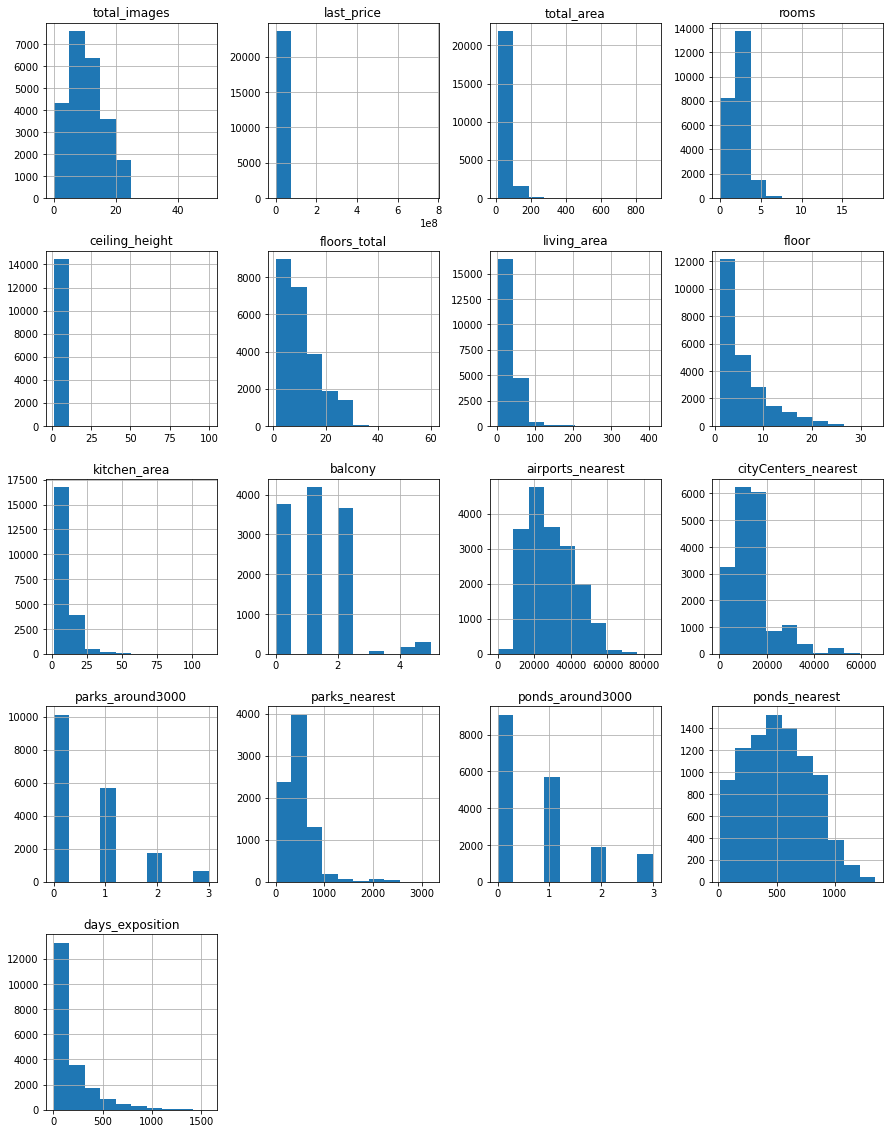

In [73]:
import matplotlib.pyplot as plt
data_realty = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data_realty.info()
data_realty.hist(figsize=(15,20))
plt.show()

В данном шаге выводим основную информацию о датафрейме с помощью метода info(), а также визуализируем в виде гистограмм все числовые столбцы датафрейма. На данном этапе можно сделать вывод о том, что некоторые столбцы имеют подобие нормального (Пуассоновского) распределения, хотя можно заметить свои пики и выбросы, что, несомненно, требует дополнительной обработки данных для дальнейшего анализа.

### Выполните предобработку данных

Во многих колонках можно заменить пропущенные значения, нужно поменять тип данных (в столбце "is_apartment"), поэтому пока заменим значения там, где это возможно. Это столбцы balcony, is_apartment, ponds_around3000, parks_around3000, kitchen_area (их могли не указать, так как в квартире нет балконов, либо она не является апартаментами, либо поблизости нет никаких парков и прудов, либо в квартире нет кухни)

In [74]:
data_realty['balcony'] = data_realty['balcony'].fillna(0)
data_realty['is_apartment'] = data_realty['is_apartment'].fillna(0)
data_realty['parks_around3000'] = data_realty['parks_around3000'].fillna(0)
data_realty['ponds_around3000'] = data_realty['ponds_around3000'].fillna(0)
#заполним пропуски на 0 или false там, где это возможно

Заменив значения там, где это возможно, нужно обработать данные: нужно обработать столбец is_apartment, так как у него булевой тип, а не object, а также first_day_exposition, т.к. должен быть тип datetime, а не object. Также введем косметические изменения - в некоторых столбцах сделаем целочисленный тип.

In [75]:
data_realty['is_apartment'] = data_realty['is_apartment'].astype(bool) #переведем тип из object в bool

In [76]:
data_realty['first_day_exposition'] = pd.to_datetime(data_realty['first_day_exposition'])

In [77]:
data_realty['balcony'] = data_realty['balcony'].astype(int)

data_realty['days_exposition'] = pd.to_numeric(data_realty['days_exposition'], errors ='coerce')

data_realty['ponds_around3000'] = data_realty['ponds_around3000'].astype(int)
data_realty['parks_around3000'] = data_realty['parks_around3000'].astype(int)

In [78]:
data_realty['floors_total'] = pd.to_numeric(data_realty['floors_total'], errors ='coerce')
data_realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Как мы видим типы данных были изменены на более удобные.

Пропущенные значения были заменены там, где это было возможно. Значения столбцов с площадью квартиры, количеством комнат, высотой потолков, этажностью дома не были заменены, так как это могло значительно исказить данные, так как эти факторы зависят от большего числа переменных - тип дома, район, год постройки и т.д.
Указание медианы в таких столбцах как parks_nearest и ponds_nearest может повлечь за собой искажение данных, так как, скажем, парках в пределах трех километров у нас нет, но медиана у нас меньше трех километров, поэтому данные могут значительно исказиться.

**Возможные причины пропусков в данных**
1. В столбце с наличием балконов пропущенное значение может означать отсутствие балкона в квартире. 
2. В столбце с типом нидвижимости пропущенное значение может говорить о том, что недвижимость не является аппартаментами
3. В столбцах с наличием парков и прудов вблизи 3 км пропущенное значение является индикатором того, что вблизи трёх километров от дома нет ни прудов, ни парков. 

In [79]:
data_realty['locality_name'].unique() #найдем уникальные значения

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [80]:
data_realty['locality_name'] = (
    data_realty['locality_name']
    .str.replace('ё','е')
    .replace(['поселок городского типа', 'городской поселок', 'поселок станции', 'поселок при железнодорожной станции', 'коттеджный поселок'], 'поселок', regex=True)
    .replace(['село Павлово'], 'поселок Павлово', regex=True)
    .replace(['село Путилово'], 'поселок Путилово', regex=True)
    .replace(['село Копорье'], 'поселок Копорье', regex=True)
    .replace(['село Старая Ладога'], 'поселок Старая Ладога', regex=True)
    .replace(['село Никольское'], 'поселок Никольское', regex=True))

Неявные дубликаты устранены.

Сделаем проверку на явные дубликаты строк.

In [81]:
data_realty.duplicated().sum()

0

Дубликаты строк отсутствуют.

Сгруппируем количество предложений по каждому населённому пункту.

In [82]:
grouped_by_locality = data_realty.groupby('locality_name').size()
print(grouped_by_locality)

locality_name
Бокситогорск                   16
Волосово                       36
Волхов                        111
Всеволожск                    398
Выборг                        237
                             ... 
садовое товарищество Садко      1
село Паша                       2
село Рождествено                3
село Русско-Высоцкое            9
село Шум                        1
Length: 317, dtype: int64


**Промежуточный вывод**

Мы устранили пропущенные значения там, где это возможно без привлечения сторонних переменных и искажения данных - а именно, в колонках с наличием балконов, типом недвижимости (апартаменты или нет), ближайший пруд и ближайший парк. Были выявлены причины пропусков. 
Удалось поправить тип данных там, где он был ошибочным.
Также удалось устранить неявные дубликаты и посчитать количество предложений по каждому населённому пункту.

### Добавьте в таблицу новые столбцы

In [83]:
data_realty['price_per_meter'] = round(data_realty['last_price'] / data_realty['total_area'], 2)

data_realty['weekday'] = data_realty['first_day_exposition'].dt.weekday
data_realty['month'] = data_realty['first_day_exposition'].dt.month
data_realty['year'] = data_realty['first_day_exposition'].dt.year

Был создан столбец с ценой за кв.метр, а также в отдельные столбцы были вынесены день недели, месяц и год.

In [84]:
def get_floor_type(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
data_realty['floor_type'] = data_realty[['floor', 'floors_total']].apply(lambda x: get_floor_type(x[0], x[1]), axis=1)

Был создан столбец с типом этажа. Для этого пришлось создать функцию, параметры которой этаж и этажность дома, но для каждой конкретной строки в датафрейме применялась лямбда функция, в которой лежит основная функция get_floor_type. 

In [85]:
data_realty['distance_to_center_km'] = round(data_realty['cityCenters_nearest'] / 1000)

Создан столбец с расстоянием до центра в километрах.

**Результат этапа.** 
Были добавлены столбцы с ценой за квадратный метр, днем недели, месяцем, годом, типом этажа и расстоянием до центра в километрах. Это может значительно облегчить дальнейший анализ данных.

### Проведите исследовательский анализ данных

Рассмотрим графики.

(0.0, 300.0)

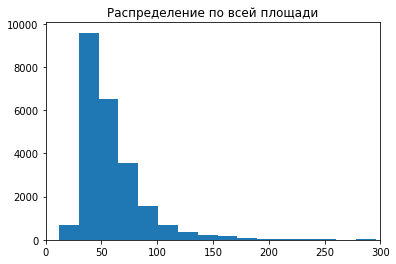

In [86]:
plt.hist(data_realty['total_area'], bins = 50)
plt.title('Распределение по всей площади')
plt.xlim(0, 300)

(10.0, 200.0)

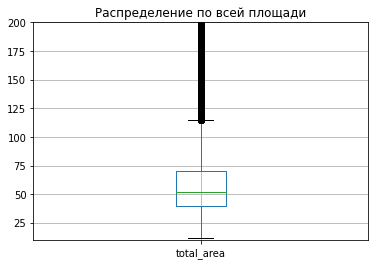

In [87]:
data_realty.boxplot('total_area')
plt.title('Распределение по всей площади')
plt.ylim(10, 200)

Видим большое количество выбросов - недвижимость, которая больше 120 кв.м.
Судя по гистограмме и боксплоту - основные значения расположились в районе 50 кв.м. Основные предложения по продаже недвижимости расположены в рамках до 120 кв. м.

(0.0, 200.0)

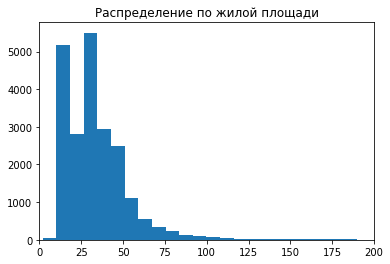

In [88]:
plt.hist(data_realty['living_area'], bins = 50)
plt.title('Распределение по жилой площади')
plt.xlim(0, 200)

(10.0, 200.0)

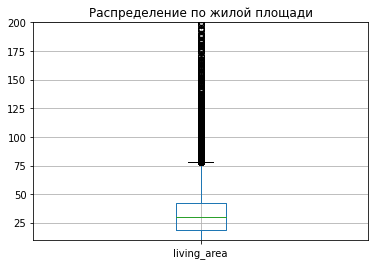

In [89]:
data_realty.boxplot('living_area')
plt.title('Распределение по жилой площади')
plt.ylim(10, 200)

Почти то же самое мы видим и в графике жилой площади, только выбросы начинаются уже с 80 кв.м. Медиана же уменьшилась почти в 2 раза. Также видим большое количество недвижимости меньше 20 кв.м. Можно предположить, что это студии, апартаменты или складские помещения.

(0.0, 50.0)

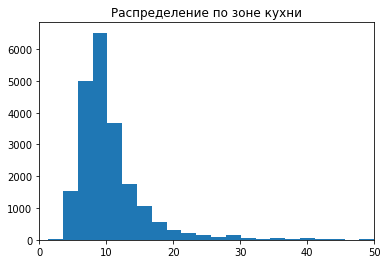

In [90]:
plt.hist(data_realty['kitchen_area'], bins = 50)
plt.title('Распределение по зоне кухни')
plt.xlim(0, 50)

(0.0, 50.0)

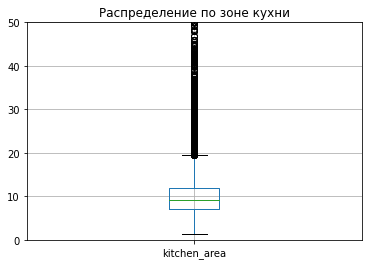

In [91]:
data_realty.boxplot('kitchen_area')
plt.title('Распределение по зоне кухни')
plt.ylim(0, 50)

Тут имеем такую же картину, много выбросов, медиана на уровне 10 кв.м. Выше 20 кв.м. наблюдаем выбросы.

(0.0, 50000000.0)

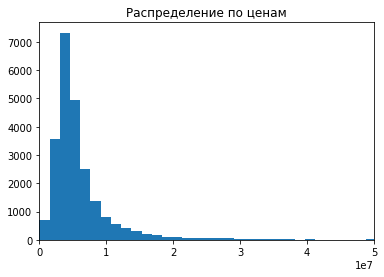

In [92]:
plt.hist(data_realty['last_price'], bins = 500)
plt.title('Распределение по ценам')
plt.xlim(0, 50000000)

(0.0, 20000000.0)

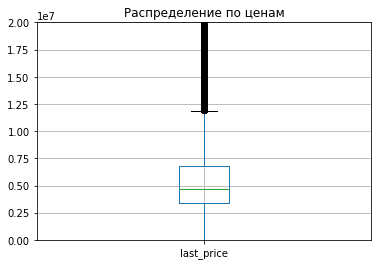

In [93]:
data_realty.boxplot('last_price')
plt.title('Распределение по ценам')
plt.ylim(0, 20000000)

Как мы видим, медианные значения колеблются в районе 5 млн. рублей, а основной диапазон цен - недвижимость до 12 млн. рублей. Дальше идут выбросы, которые выстраиваюся в единую линию.

Text(0.5, 1.0, 'Распределение по комнатам')

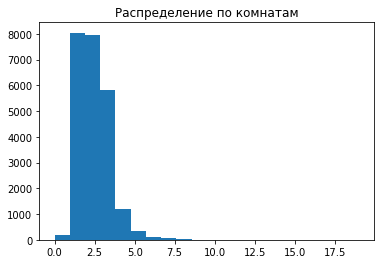

In [94]:
plt.hist(data_realty['rooms'], bins = 20)
plt.title('Распределение по комнатам')

Text(0.5, 1.0, 'Распределение по комнатам')

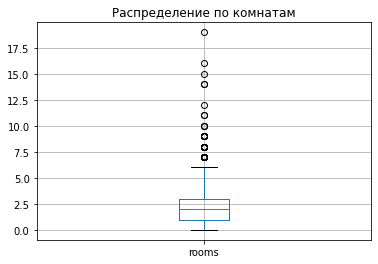

In [95]:
data_realty.boxplot('rooms')
plt.title('Распределение по комнатам')

На данном графике мы видим не так много выбросов - основной диапазон недвижимости от студий до 6-ти комнатных квартир, а дальше идут выбросы, которых уже не так много по сравнению с другими графиками.

(0.0, 10.0)

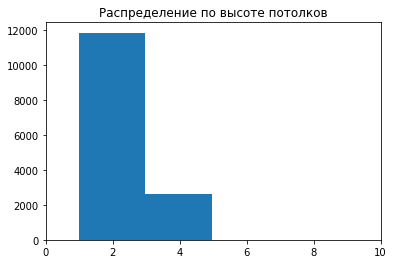

In [96]:
plt.hist(data_realty['ceiling_height'], bins = 50)
plt.title('Распределение по высоте потолков')
plt.xlim(0,10)

(0.0, 100.0)

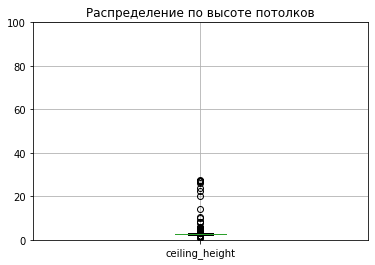

In [99]:
data_realty.boxplot('ceiling_height')
plt.title('Распределение по высоте потолков')
plt.ylim(0,100)

Невооруженным глазом видно аномалии - потолки высотой 25, 30 и даже 100 метров. Попробуем обработать данные выбросы.

In [98]:
data_realty['ceiling_height'] = (data_realty['ceiling_height'].replace([25], 2.5, regex=True).replace([32], 3.2, regex=True).replace([100], 10, regex=True))

(0.0, 10.0)

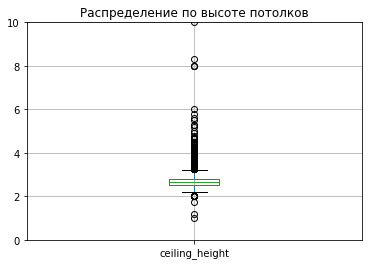

In [28]:
data_realty.boxplot('ceiling_height')
plt.title('Распределение по высоте потолков')
plt.ylim(0,10)

Теперь аномалий нет. Можно сказать, что основной диапазон потолков расположен от 2.5 до 3.5 метров. Выбросы можно объяснить крупной недвижимостью. 

Text(0.5, 1.0, 'Распределение по типу этажа')

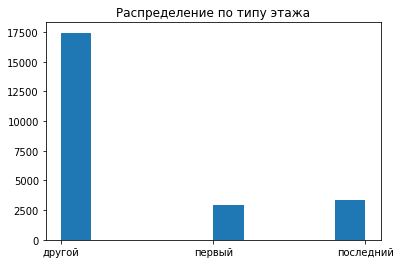

In [29]:
plt.hist(data_realty['floor_type'])
plt.title('Распределение по типу этажа')

Как можно заметить, квартиры на первом и последнем этаже в меньшинстве, но квартир на последних этажах больше, чем на первом.

Text(0.5, 1.0, 'Распределение по этажам')

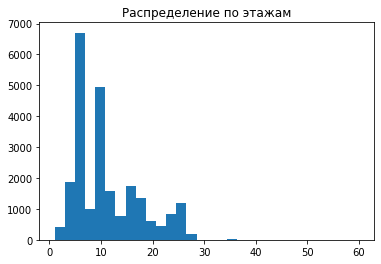

In [30]:
plt.hist(data_realty['floors_total'], bins = 30)
plt.title('Распределение по этажам')

Text(0.5, 1.0, 'Распределение по этажам')

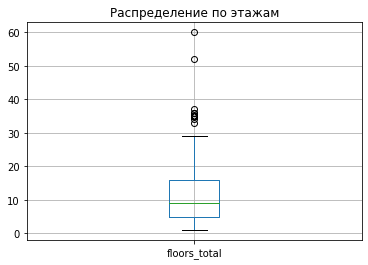

In [31]:
data_realty.boxplot('floors_total')
plt.title('Распределение по этажам')

Как мы видим - диапазон основных значений от 1 до почти 30 этажей, а выбросы могут быть вызваны продажей недвижимости в многоэтажных постройках или небоскребах, по типу Лахта-центра. 

Text(0.5, 1.0, 'Распределение по расстоянию до центра')

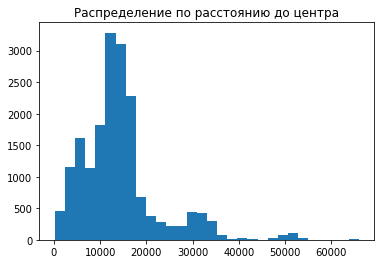

In [32]:
plt.hist(data_realty['cityCenters_nearest'], bins = 30)
plt.title('Распределение по расстоянию до центра')

Text(0.5, 1.0, 'Распределение по расстоянию до центра')

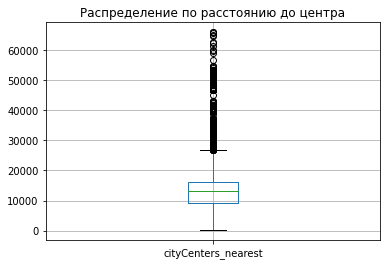

In [33]:
data_realty.boxplot('cityCenters_nearest')
plt.title('Распределение по расстоянию до центра')

Как мы видим основные значения распределены в районе 5-20км от центра города (а медиана примерно на 13км), что может говорить о том, что квартиры на продаже в основном в пригороде.

Text(0.5, 1.0, 'Распределение по ближайшим паркам')

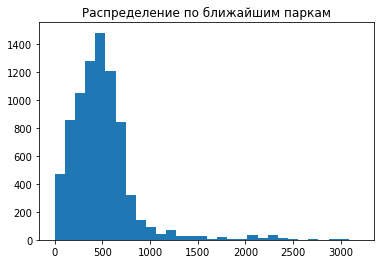

In [34]:
plt.hist(data_realty['parks_nearest'], bins = 30)
plt.title('Распределение по ближайшим паркам')

Text(0.5, 1.0, 'Распределение по ближайшим паркам')

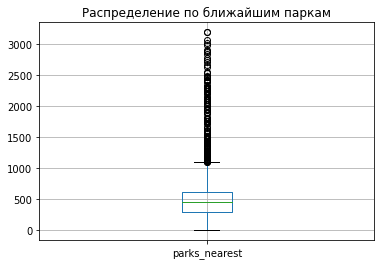

In [35]:
data_realty.boxplot('parks_nearest')
plt.title('Распределение по ближайшим паркам')

Как мы видим, основной массив недвижимости находится в пределах 1км от ближайшего парка, но можно заметить и большое количество выбросов, которые могут быть связаны с загородной недвижимостью - парков там не много.

**Рассмотрим то, как быстро продавались квартиры**

(array([13267.,  3565.,  1746.,   871.,   455.,   275.,   182.,    92.,
           49.,    16.]),
 array([1.0000e+00, 1.5890e+02, 3.1680e+02, 4.7470e+02, 6.3260e+02,
        7.9050e+02, 9.4840e+02, 1.1063e+03, 1.2642e+03, 1.4221e+03,
        1.5800e+03]),
 <BarContainer object of 10 artists>)

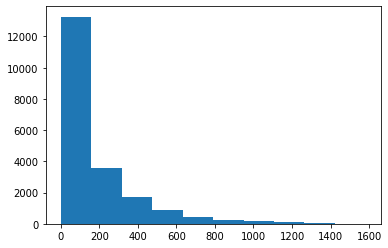

In [36]:
plt.hist(data_realty['days_exposition'])

Среднее: 180.88863436982163 Медиана: 95.0


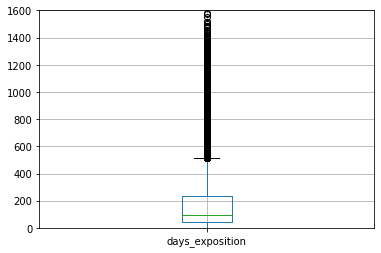

In [37]:
data_realty.boxplot('days_exposition')
plt.ylim(0, 1600)
print('Среднее:', data_realty['days_exposition'].mean(), 'Медиана:', data_realty['days_exposition'].median())

Как мы видим среднее и медиана отличаются больше чем в полтора раза, это может быть связано с выбросами - необычайно долгими продажами. Некоторые значения настолько велики, что это значительно влияет на значение среднего.
Период быстрой продажи - до 95 дней, именно до этого периода распродается половина всей недвижимости на платформе. 
Необычайно долгим можно считать период больше 400 дней, так как значение непроданных квартир начинает сокращаться и постепенно переходить в раздел "выбросов", как можно заметить в "ящике с усами".

Рассмотрим зависимость цены от нескольких факторов, а именно - общая площадь, жилая площадь, площадь кухни, количество комнат, тип этажа, на котором расположена квартира (первый, последний, другой), дата размещения (день недели, месяц, год).

,total_area,last_price
total_area,1.000000,0.653675
last_price,0.653675,1.000000


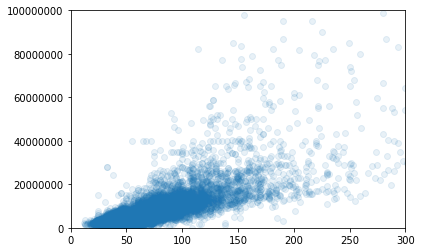

In [38]:
plt.scatter(data_realty['total_area'], data_realty['last_price'], alpha=0.1)
plt.xlim(0,300)
plt.ylim(0,100000000)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False) #захотелось убрать le8
data_realty[['total_area', 'last_price']].corr()

Из таблицы и графика можно заметить, что общая площадь и цена имеют среднюю положительную корреляцию. То есть можно сказать, что чем выше площадь, тем больше цена, но опять же есть категории недвижимости, которые делают корреляцию не стопроцентной, например, элитная недвижимость, где площадь может не сильно влиять на стоимость.

,living_area,last_price
living_area,1.000000,0.566492
last_price,0.566492,1.000000


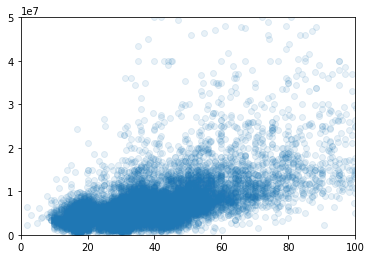

In [39]:
plt.scatter(data_realty['living_area'], data_realty['last_price'], alpha=0.1)
plt.xlim(0,100)
plt.ylim(0,50000000)
data_realty[['living_area', 'last_price']].corr()

Из таблицы корреляции и графика видно, что есть корреляция, но и выбивающихся значений тоже много, об этом говорит и коэфициент корреляции Пирсона 0,56, это говорит об умеренной корреляции, то есть **в большинстве случаев мы можем утверждать, что чем выше жилая площадь, тем больще цена.**

,kitchen_area,last_price
kitchen_area,1.000000,0.519869
last_price,0.519869,1.000000


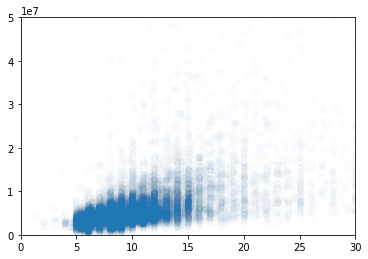

In [40]:
plt.scatter(data_realty['kitchen_area'], data_realty['last_price'], alpha=0.01)
plt.xlim(0,30)
plt.ylim(0,50000000)
data_realty[['kitchen_area', 'last_price']].corr()

Из таблицы и диаграммы можно увидеть, что значения цены в некоторых случаях действительно коррелирует с размером кухни, но это далеко не все случаи. Исходя из коэфициента корреляции, можно **утверждать об умеренной корреляции и строить какие либо причинно следственные связи**, но в некоторых выбивающихся случаев лучше подключить дополнительные параметры.

In [41]:
data_realty[['rooms', 'last_price']].corr()

,rooms,last_price
rooms,1.000000,0.363343
last_price,0.363343,1.000000


<AxesSubplot:xlabel='rooms'>

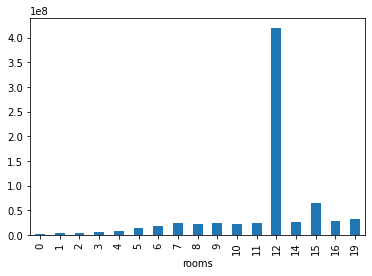

In [44]:
medians_by_rooms = data_realty.groupby('rooms')['last_price'].median()
medians_by_rooms.plot.bar()

<AxesSubplot:xlabel='rooms'>

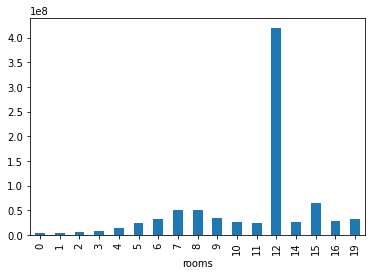

In [45]:
means_by_rooms = data_realty.groupby('rooms')['last_price'].mean()
means_by_rooms.plot.bar()

Небольшой коэфициент корреляции и барплоты по средним значениям и медианам говорят о том, что количество комнат не сильно влияет на цену недвижимости, но мы видим определённую тенденцию, что чем больше комнат, тем выше стоимость. Эту тенденцию сбивают квартиры с 8+ комнатами меньше чем за 5млн, это можно объяснить тем, что продавец указал количество комнат, но на деле продаёт долю в квартире.

<AxesSubplot:xlabel='floor_type'>

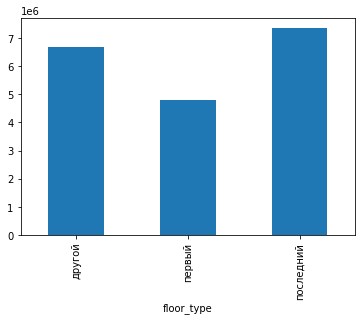

In [46]:
means_by_floor_type = data_realty.groupby('floor_type')['last_price'].mean()
means_by_floor_type.plot.bar()

<AxesSubplot:xlabel='floor_type'>

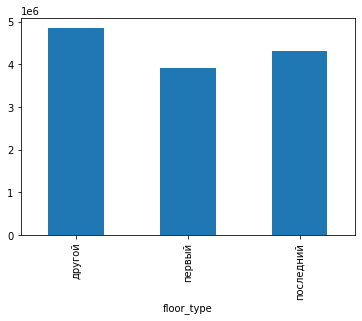

In [48]:
medians_by_floor_type = data_realty.groupby('floor_type')['last_price'].median()
medians_by_floor_type.plot.bar()

Как можно заметить из этого столбчатого графика по средним и медианным значениям - они не сильно отличаются друг от друга, но квартиры на первых и последних этажах чуть дешевле, чем на других.

<AxesSubplot:xlabel='weekday'>

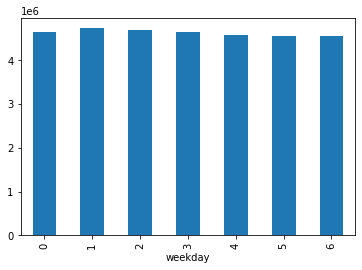

In [51]:
medians_by_weekday = data_realty.groupby('weekday')['last_price'].median()
medians_by_weekday.plot.bar()

<AxesSubplot:xlabel='weekday'>

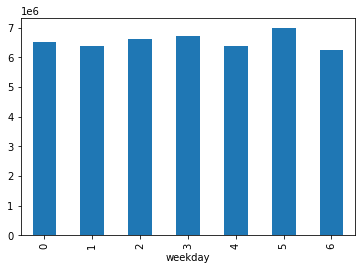

In [50]:
means_by_weekday = data_realty.groupby('weekday')['last_price'].mean()
means_by_weekday.plot.bar()

Судя по средним и медианным значениям - день недели не влияет на распределение средних и медианных значений, поэтому он никак не влияет на цену.

<AxesSubplot:xlabel='month'>

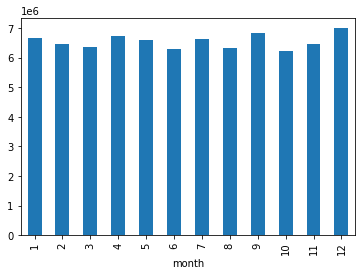

In [52]:
means_by_month = data_realty.groupby('month')['last_price'].mean()
means_by_month.plot.bar()

<AxesSubplot:xlabel='month'>

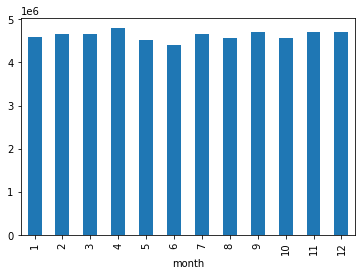

In [54]:
medians_by_month = data_realty.groupby('month')['last_price'].median()
medians_by_month.plot.bar()

То же самое можно сказать и с месяцами.

<AxesSubplot:xlabel='year'>

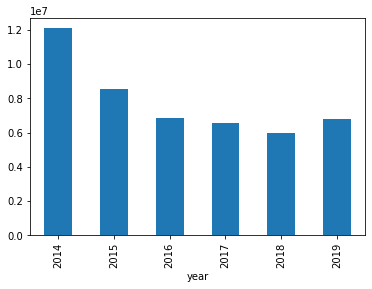

In [56]:
means_by_year = data_realty.groupby('year')['last_price'].mean()
means_by_year.plot.bar()

<AxesSubplot:xlabel='year'>

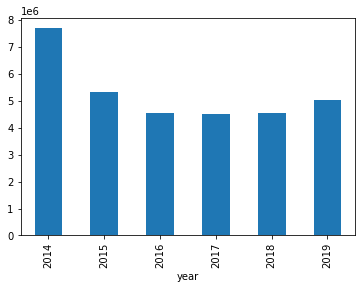

In [55]:
medians_by_year = data_realty.groupby('year')['last_price'].median()
medians_by_year.plot.bar()

А вот в зависимости от года мы видим снижение и возрастание средних и медианных значений. Влияние на цены можно объяснить событиями, которые происходили в те годы, и экономической обстановкой. Тем не менее, месяц и день недели публикации **никак** не влияет на цены квартир.

**Посчитаем среднюю стоимость квадратного метра в 10 населённых пунктах с наибольшим количеством объявлений.**

                   Количество предложений  Средняя цена за кв.м.
Санкт-Петербург                   15721.0          124514.621378
поселок Мурино                      556.0           83081.092636
поселок Шушары                      440.0           76328.217594
Всеволожск                          398.0           67635.128626
Пушкин                              369.0          105097.361245
Колпино                             338.0           74467.617484
поселок Парголово                   327.0           87110.874551
Гатчина                             307.0           68475.381534
деревня Кудрово                     299.0           90916.895213
Выборг                              237.0           57898.142109


/tmp/ipykernel_67/2681638080.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_price = data_realty.groupby('locality_name')['last_price', 'total_area'].mean()


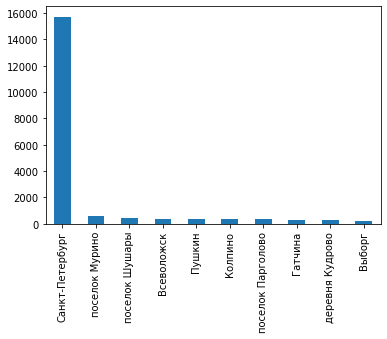

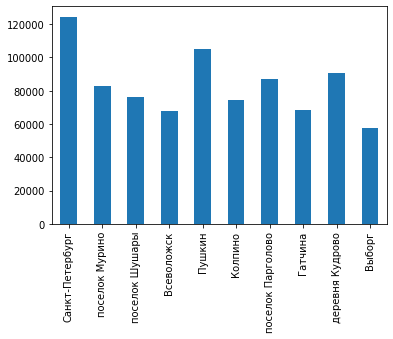

In [60]:
top_10_locations = data_realty['locality_name'].value_counts().sort_values(ascending=False).head(10)
mean_price = data_realty.groupby('locality_name')['last_price', 'total_area'].mean()

top_table = pd.DataFrame({
        'Количество предложений': top_10_locations,
        'Средняя цена за кв.м.': mean_price['last_price'] / mean_price['total_area']})
top_table_sorted = top_table.sort_values(by='Количество предложений',ascending=False).head(10)
print(top_table_sorted)
top_table_sorted['Количество предложений'].plot.bar()
plt.show()
top_table_sorted['Средняя цена за кв.м.'].plot.bar()
plt.show()

Самая высокая цена наблюдается в Санкт-Петербурге и Пушкине, там стоимость квадратного метра начинается от 100 тысяч рублей. Самая низкая же цена наблюдается в Выборге, Всеволожске и Гатчине - стоимость квадратного метра там до 70 тысяч рублей.

**Выделим квартиры в Санкт-Петербурге и рассчитаем среднюю стоимость на разном расстоянии от центра.**

In [49]:
data_realty = data_realty[data_realty['locality_name'] == 'Санкт-Петербург']

In [50]:
distance_to_center_prices = data_realty.groupby('distance_to_center_km')['last_price'].mean()

(0.0, 50000000.0)

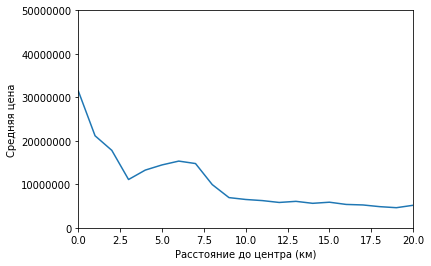

In [51]:
plt.plot(distance_to_center_prices.index, distance_to_center_prices)
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlim(0,20)
plt.ylim(0,50000000)

Как видно из графика цена значительно падает когда мы отдаляемся от центра на 2.5 км, до 7,5 км цены держатся почти на одном уровне и даже заметен небольшой рост. После же наблюдается падение и плато - примерно после 10 км цены почти не падают. 

**Промежуточные итоги**

Распределение данных по определенным значениям:

**Общая площадь:**

* Много выбросов (> 120 кв.м.).
* Основные значения: 50 кв.м.
* Предложения: до 120 кв.м.

**Жилая площадь:**

* Аналогично общей площади, но выбросы с 80 кв.м.
* Медиана в 2 раза меньше.
* Много объектов < 20 кв.м. (студии, апартаменты, склады).

**Площадь кухни:**

* Много выбросов, медиана 10 кв.м.
* Выбросы > 20 кв.м.

**Цена квартиры:**

* Медиана: 5 млн. рублей.
* Основной диапазон: до 12 млн. рублей.
* Дальше идут выбросы.

**Количество комнат:**

* Не много выбросов.
* Основной диапазон: от студий до 6-комнатных.

**Высота потолков:**

* Нет аномалий.
* Основной диапазон: 2.5 - 3.5 метров.
* Выбросы: крупная недвижимость.

**Тип этажа:**

* Квартиры на 1-ом и последнем этажах в меньшинстве.
* На последних этажах больше, чем на первом.

**Количество этажей:**

* Основной диапазон: 1 - 30 этажей.
* Выбросы: многоэтажные постройки/небоскребы.

**Расстояние до центра города:**

* Основные значения: 5-20 км (медиана 13 км).
* Квартиры на продаже в основном в пригороде.

**Расстояние до ближайшего парка:**

* Основной массив: в 1 км от парка.
* Выбросы: загородная недвижимость (парков мало).

**Сколько дней было размещено объявление**

* Среднее и медиана продаж значительно различаются, что указывает на наличие выбросов, вероятно, связанных с необычайно долгими продажами. Быстрые продажи обычно заканчиваются в течение 95 дней, но есть и объекты, которые не проданы в течение более 400 дней.

Анализ корреляций:

* **Общая площадь и цена:**
* Средняя положительная корреляция (коэффициент корреляции Пирсона 0,56).
* Элитная недвижимость может выбиваться из корреляции.
* **Жилая площадь и цена:**
* Умеренная корреляция (коэффициент корреляции Пирсона 0,56).
* В некоторых случаях выбивающиеся значения.
* **Площадь кухни и цена:**
* Умеренная корреляция (коэффициент корреляции Пирсона 0,45).
* Нужны дополнительные параметры для анализа выбивающихся значений.
* **Количество комнат и цена:**
* Несильная зависимость.
* Тенденция к увеличению цены с увеличением количества комнат.
* Квартиры с 8+ комнатами дешевле 5 млн. рублей могут быть долями.

Анализ других факторов:

* **Тип этажа:**
* Квартиры на первых и последних этажах немного дешевле.
* **День недели публикации:**
* Не влияет на цену.
* **Месяц публикации:**
* Не влияет на цену.
* **Год публикации:**
* Влияет на цену (зависит от событий и экономической обстановки).
* **Район:**
* Влияет на цену (самые высокие цены в СПб и Пушкине, самые низкие - в Выборге, Всеволожске и Гатчине).
* **Расстояние до центра:**
* Цена падает на 2.5 км от центра, затем держится на одном уровне до 7.5 км, после чего снова падает.

### Напишите общий вывод

**Общий вывод:**

**1. Очистка данных:**

* Устранены пропуски в данных, определены их причины.
* Исправлен тип данных в нескольких столбцах.
* Удалено множество неявных дублей.
* Посчитано количество предложений по каждому населенному пункту.

**2. Добавленные столбцы:**

* Цена за квадратный метр, день недели, месяц, год, тип этажа, расстояние до центра (км).

**3. Распределение данных:**

* **Общая площадь:**
* Медиана: 50 кв.м.
* Основной диапазон: до 120 кв.м.
* Много выбросов (> 120 кв.м.).
* **Жилая площадь:**
* Медиана в 2 раза меньше, чем у общей площади.
* Много объектов < 20 кв.м. (студии, апартаменты, склады).
* В остальном схожа с распределением общей площади.
* **Площадь кухни:**
* Медиана: 10 кв.м.
* Много выбросов (> 20 кв.м.).
* **Цена квартиры:**
* Медиана: 5 млн. рублей.
* Основной диапазон: до 12 млн. рублей.
* Дальше идут выбросы.
* **Количество комнат:**
* Основной диапазон: от студий до 6-комнатных.
* Не много выбросов.
* **Высота потолков:**
* Основной диапазон: 2.5 - 3.5 метров.
* Нет аномалий.
* **Тип этажа:**
* Квартиры на 1-ом и последнем этажах в меньшинстве.
* На последних этажах больше, чем на первом.
* **Количество этажей:**
* Основной диапазон: 1 - 30 этажей.
* Выбросы: многоэтажные постройки/небоскребы.
* **Расстояние до центра города:**
* Основные значения: 5-20 км (медиана 13 км).
* Квартиры на продаже в основном в пригороде.
* **Расстояние до ближайшего парка:**
* Основной массив: в 1 км от парка.
* Выбросы: загородная недвижимость (парков мало).

**4. Сроки продажи:**

* Среднее и медиана продаж значительно различаются.
* Быстрые продажи (до 95 дней) составляют 60%.
* 10% объектов не проданы в течение более 400 дней.

**5. Анализ корреляций:**

* **Общая площадь и цена:**
* Средняя положительная корреляция (коэффициент корреляции Пирсона 0,56).
* Элитная недвижимость может выбиваться из корреляции.
* **Жилая площадь и цена:**
* Умеренная корреляция (коэффициент корреляции Пирсона 0,56).
* В некоторых случаях выбивающиеся значения.
* **Площадь кухни и цена:**
* Умеренная корреляция (коэффициент корреляции Пирсона 0,45).
* Нужны дополнительные параметры для анализа выбивающихся значений.
* **Количество комнат и цена:**
* Несильная зависимость.
* Тенденция к увеличению цены с увеличением количества комнат.
* Квартиры с 8+ комнатами дешевле 5 млн. рублей могут быть долями.

**6. Анализ других факторов:**

* **Тип этажа:**
* Квартиры на первых и последних этажах немного дешевле.
* **День недели публикации:**
* Не влияет на цену.
* **Месяц публикации:**
* Не влияет на цену.
* **Год публикации:**
* Влияет на цену (зависит от событий и экономической обстановки).
* **Район:**
* Влияет на цену (самые высокие цены в СПб и Пушкине, самые низкие - в Выборге, Всеволожске и Гатчине).
* **Расстояние до центра:**
* Цена падает на 2.5 км от центра, затем держится на одном уровне до 7.5 км, после чего снова падает.

**7. Заключение:**

Проделанная работа по очистке и анализу данных позволит вам эффективно использовать информацию для решения ваших задач.